# **Parseval Network**

# **Data Preparation**

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

In [2]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
import cv2
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(cv2.resize(row['crop'], (32,32)))
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 32, 32)

In [3]:
X = new_data_X.astype('float32')
X.shape

(5722, 32, 32)

In [0]:
img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [6]:
y_df['Label'].value_counts()

closed           1500
open             1500
partiallyOpen    1376
notVisible       1346
Name: Label, dtype: int64

In [7]:
y_df['Encoded'].value_counts()


2    1500
0    1500
3    1376
1    1346
Name: Encoded, dtype: int64

In [0]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

# Othogonal Constraint

In [0]:
from tensorflow.python.keras.constraints import Constraint
from tensorflow.python.ops import math_ops, array_ops

class TightFrame(Constraint):


    def __init__(self, scale, num_passes=1):
        self.scale = scale

        if num_passes < 1:
            raise ValueError("Number of passes cannot be non-positive! (got {})".format(num_passes))
        self.num_passes = num_passes


    def __call__(self, w):
        transpose_channels = (len(w.shape) == 4)

        # Move channels_num to the front in order to make the dimensions correct for matmul
        if transpose_channels:
            w_reordered = array_ops.reshape(w, (-1, w.shape[0]))

        else:
            w_reordered = w

        last = w_reordered
        for i in range(self.num_passes):
            temp1 = math_ops.matmul(last, last, transpose_a=True)
            temp2 = (1 + self.scale) * w_reordered - self.scale * math_ops.matmul(w_reordered, temp1)

            last = temp2

        # Move channels_num to the back again
        if transpose_channels:
            return array_ops.reshape(last, w.shape)
        else:
            return last


    def get_config(self):
        return {'scale': self.scale, 'num_passes': self.num_passes}


# Alias
tight_frame = TightFrame

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings("ignore")
weight_decay = 0.0001


**Parseval Network**

In [31]:


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal', kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal', kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      kernel_constraint= tight_frame(0.0001),
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_parseval_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, activation='softmax' )(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":

    init = (32, 32,1)

    parseval_16_2 = create_parseval_network(init, nb_classes=4, N=2, k=2, dropout=0.5)

conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.callbacks as callbacks


In [0]:
EPOCHS = 200
BS = 128


In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.1, momentum=0.6)

In [37]:
parseval_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
import tensorflow
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
def lr_sch(epoch):
    if epoch < 30:
        return 0.1
    elif epoch < 50:
        return 0.001
    elif epoch < 60:
        return 0.001
    else:
        return 0.00001

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [38]:
from tensorflow.keras.utils import to_categorical
hist = parseval_16_2.fit(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   validation_data=(X_val, y_val),
                   callbacks = [lr_scheduler],
                   validation_steps=X_val.shape[0] // BS,)

Epoch 1/200
36/36 [==============================] - 2s 47ms/step - loss: 1.4425 - acc: 0.3282 - val_loss: 1.3903 - val_acc: 0.3184 - lr: 0.1000
Epoch 2/200
36/36 [==============================] - 1s 38ms/step - loss: 1.3509 - acc: 0.3609 - val_loss: 1.3531 - val_acc: 0.3767 - lr: 0.1000
Epoch 3/200
36/36 [==============================] - 1s 38ms/step - loss: 1.3302 - acc: 0.3693 - val_loss: 1.3332 - val_acc: 0.3709 - lr: 0.1000
Epoch 4/200
36/36 [==============================] - 1s 39ms/step - loss: 1.2992 - acc: 0.3837 - val_loss: 1.2853 - val_acc: 0.4214 - lr: 0.1000
Epoch 5/200
36/36 [==============================] - 1s 38ms/step - loss: 1.2812 - acc: 0.4008 - val_loss: 1.5108 - val_acc: 0.3398 - lr: 0.1000
Epoch 6/200
36/36 [==============================] - 1s 38ms/step - loss: 1.2760 - acc: 0.4141 - val_loss: 1.2721 - val_acc: 0.3903 - lr: 0.1000
Epoch 7/200
36/36 [==============================] - 1s 38ms/step - loss: 1.2424 - acc: 0.4390 - val_loss: 1.2458 - val_acc: 0.433

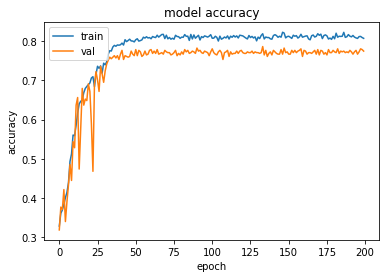

In [39]:
from matplotlib import  pyplot

pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'val'], loc='upper left')
pyplot.show()

In [0]:
test_err = [1.0-x for x in hist.history['val_acc']]

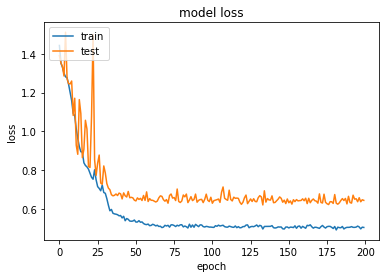

In [40]:
# summarize history for loss
pyplot.plot(hist.history['loss'])
pyplot.plot(hist.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()


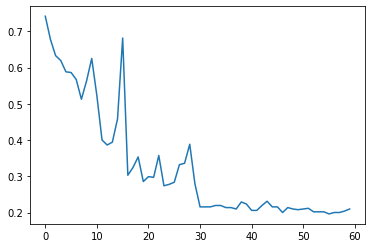

In [41]:
pyplot.plot(test_err, label='test')
pyplot.savefig("deneme_err.png")

In [0]:
import tensorflow as tf
parseval_16_2.save("parseval_OC.h5")

In [0]:
y_pred = parseval_16_2.predict(X_test)

In [42]:
parseval_16_2.evaluate(X_test,y_test)

18/18 [==============================] - 0s 6ms/step - loss: 0.6308 - acc: 0.7801


[0.6308341026306152, 0.7801046967506409]

In [43]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 50kB/s 
     |████████████████████████████████| 3.1MB 54.1MB/s 
     |████████████████████████████████| 501kB 57.4MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-u1dk9_r8/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-u1dk9_r8/cleverhans
     |████████████████████████████████| 163kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=28d39351687d2151ccd5a02bd9669df895ce80ef41817b278a3d6d4612991ccf
  Stored in directory: /tmp/pip-ephem-wheel-cache-hmh2e0iv/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(parseval_16_2.input,parseval_16_2.layers[-1].output)

**Non-Adversarial Training**

In [0]:
X_adv = []
epsilon_list = [0.005]
for j in range(len(epsilon_list)):
  epsilon = epsilon_list[j]
  for i in range(len(X_test)):
    random_index = i
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_test[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))

In [53]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,parseval_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 4ms/step - loss: 2.8286 - acc: 0.2356
epsilon: 0.1 and test evalution : [2.8285772800445557, 0.23560209572315216]


In [55]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,parseval_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 5ms/step - loss: 0.7395 - acc: 0.6963
epsilon: 0.01 and test evalution : [0.7394983172416687, 0.6963350772857666]


In [61]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,parseval_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 4ms/step - loss: 0.6521 - acc: 0.7469
epsilon: 0.005 and test evalution : [0.6521332859992981, 0.7469459176063538]
